In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# !pip install git+https://github.com/geoopt/geoopt.git

In [3]:
import torch
import geoopt
import tqdm
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE

from icecream import ic


# Load Data

In [4]:
device = 'cuda'

In [5]:
path = '../data/processed/mixture_embeddings/ibd/cnn_hyperbolic_2_mixture_embeddings.csv'
mixture_embeddings = pd.read_csv(path, index_col='Sample')
mixture_embeddings

,0,1
Sample,,
CSM5FZ3N,0.000000,0.000000
CSM5FZ3X,0.000000,0.000000
CSM5FZ3Z,-0.019282,0.780946
CSM5FZ44,0.000000,0.000000
CSM5FZ46,0.000000,0.000000
...,...,...
MSM5LLIO,-0.187492,0.394580
MSM5LLIQ,-0.359186,0.083998
MSM5LLIS,-0.237867,0.063742


In [6]:
path = '../data/interim/ihmp/ibd_metadata.csv'
metadata = pd.read_csv(path, index_col='Sample')
metadata.columns.to_list()

['Participant',
 'Sample Collection Date',
 'Visit Number',
 'Hospital',
 'Age',
 'Diagnosis',
 'HBI',
 'Sex',
 'Race',
 'Fecalcal',
 'SCCAI',
 'fb ratio']

In [7]:
class Dataset(torch.utils.data.Dataset):
    
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [8]:
class DatasetTest(torch.utils.data.Dataset):
    
    def __init__(self, X):
        self.X = X
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx]

In [9]:
feature = 'Hospital'
task = 'clf'

# feature = 'fb ratio'
# task = 'reg'

In [10]:
X = mixture_embeddings.values.astype('float32')
y = metadata[feature].to_numpy()

if task == 'clf':
    encoder = LabelEncoder()
    y = encoder.fit_transform(y)

if feature == 'Diagnosis':
    mask = y != 2
    y = y[mask]
    X = X[mask]
    
if feature == 'fb ratio':
    y = np.nan_to_num(y, np.nanmean(y))

seed = 42
stratify = None if task == 'reg' else y
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, stratify=stratify, shuffle=True)

sm = SMOTE(random_state=seed, sampling_strategy='not minority')
X_syn, y_syn = sm.fit_resample(X_train, y_train)

# X_train = np.vstack((X_train, X_syn))
# y_train = np.hstack((y_train, y_syn))

dataset = Dataset(X_train, y_train)
dataset_test = DatasetTest(X_test)

In [11]:
y_train

array([3, 3, 2, 1, 1, 3, 0, 3, 0, 3, 3, 0, 3, 3, 0, 1, 1, 0, 3, 2, 1, 0,
       0, 1, 3, 3, 3, 3, 3, 1, 3, 2, 0, 0, 3, 3, 2, 1, 1, 3, 2, 3, 1, 3,
       2, 0, 3, 3, 0, 1, 3, 2, 2, 0, 2, 3, 2, 3, 0, 3, 0, 1, 0, 3, 0, 0,
       3, 3, 0, 1, 2, 3])

In [12]:
num_classes = max(y) + 1

# Define model

In [13]:
ball = geoopt.PoincareBall()
torch.manual_seed(42)

In [14]:
class Distance2PoincareHyperplanes(torch.nn.Module):
    n = 0
    # 1D, 2D versions of this class ara available with a one line change
    # class Distance2PoincareHyperplanes2d(Distance2PoincareHyperplanes):
    #     n = 2

    def __init__(
        self,
        plane_shape: int,
        num_planes: int,
        signed=True,
        squared=False,
        *,
        ball,
        std=1.0,
        device='cuda'
    ):
        super().__init__()
        self.signed = signed
        self.squared = squared
        # Do not forget to save Manifold instance to the Module
        self.ball = ball
        self.plane_shape = geoopt.utils.size2shape(plane_shape)
        self.num_planes = num_planes
        self.device = device

        # In a layer we create Manifold Parameters in the same way we do it for
        # regular pytorch Parameters, there is no difference. But geoopt optimizer
        # will recognize the manifold and adjust to it
        self.points = geoopt.ManifoldParameter(
            torch.empty(num_planes, plane_shape), manifold=self.ball
        ).to(device)
        self.std = std
        # following best practives, a separate method to reset parameters
        self.reset_parameters()

    def forward(self, input):
        input_p = input.unsqueeze(-self.n - 1)
        points = self.points.permute(1, 0)
        points = points.view(points.shape + (1,) * self.n)
        
        distance = self.ball.dist2plane(
            x=input_p, p=points, a=points, signed=self.signed, dim=-self.n - 2
        )
        if self.squared and self.signed:
            sign = distance.sign()
            distance = distance ** 2 * sign
        elif self.squared:
            distance = distance ** 2
        return distance

    def extra_repr(self):
        return (
            "plane_shape={plane_shape}, "
            "num_planes={num_planes}, "
            .format(**self.__dict__)
        )

    @torch.no_grad()
    def reset_parameters(self):
        direction = torch.randn_like(self.points)
        direction /= direction.norm(dim=-1, keepdim=True)
        distance = torch.empty_like(self.points[..., 0]).normal_(std=self.std)
        self.points.set_(self.ball.expmap0(direction * distance.unsqueeze(-1)))

In [15]:
plane_shape = 2
num_planes = 1000
hidden = 128
last = num_classes if task == 'clf' else 1

classifier = torch.nn.Sequential(
    Distance2PoincareHyperplanes(plane_shape, num_planes, ball=ball),
    torch.nn.Linear(num_planes, hidden, device=device),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden, last, device=device),
)
classifier

Sequential(
  (0): Distance2PoincareHyperplanes(
    plane_shape=(2,), num_planes=1000, 
    (ball): PoincareBall manifold
  )
  (1): Linear(in_features=1000, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=4, bias=True)
)

In [16]:
optim = geoopt.optim.RiemannianAdam(classifier.parameters(), lr=1e-3, weight_decay=0.01)

In [17]:
criterion = torch.nn.CrossEntropyLoss()

In [18]:
batch_size = 16
loader = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)

In [19]:
device = 'cuda'
loss_history = []
n_epochs = 500

with tqdm.trange(n_epochs) as _range:
    for epoch in _range:
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            
            optim.zero_grad()
            logits = classifier(X)
            loss = criterion(logits, y)
            loss_history.append(loss.item())
            
            loss.backward()
            optim.step()
            
            if epoch % 10 == 0:
                _range.set_description(f"loss={loss.item()}")

loss=0.7653183341026306: 100%|██████████| 500/500 [00:30<00:00, 16.39it/s] 


In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

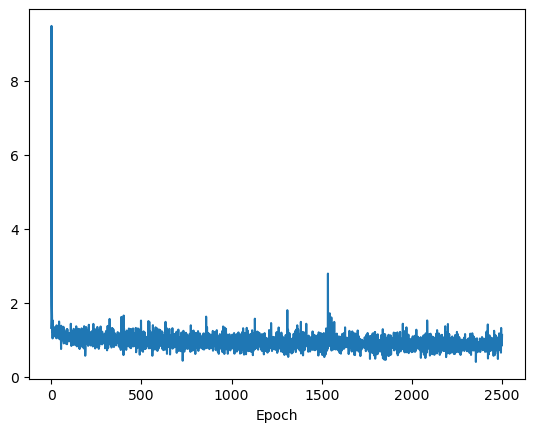

In [21]:
fig, ax = plt.subplots()
ax.plot(loss_history)
ax.set(xlabel='Epoch')

fig.show()

In [22]:
classifier.eval()
y_pred_prob = classifier(torch.Tensor(X_test).to('cuda'))
y_pred = y_pred_prob.detach().cpu().numpy().argmax(axis=1)


In [23]:
y_pred_prob

tensor([[ 1.6744e-01, -2.5398e+00, -3.1638e+00,  2.8614e+00],
        [-2.9756e-01, -1.4800e+00,  1.0061e+00,  1.8019e+00],
        [ 6.7058e+00,  5.6105e+00, -1.1562e+01,  1.0421e+01],
        [-1.0193e-01, -2.6755e+00, -1.0947e+00,  2.5673e+00],
        [-8.4116e+00,  2.2881e+00, -3.8482e+00,  3.9949e+00],
        [ 1.2226e+00,  1.6736e-01,  8.2356e-02,  3.4024e-01],
        [ 2.2213e+00,  4.6357e-01, -1.7278e+00,  1.2482e+00],
        [ 2.9598e-01, -5.0446e-01, -3.4295e+00,  1.8558e+00],
        [ 1.2226e+00,  1.6736e-01,  8.2356e-02,  3.4024e-01],
        [ 3.9084e+00,  1.4335e+00, -4.1614e+00,  1.3714e+00],
        [-2.3402e+01, -5.9987e+00,  2.2658e+01,  1.6721e+01],
        [ 2.6252e+00,  8.2768e-01, -2.5584e+00,  1.2603e+00],
        [-6.5994e+00,  1.0769e+00, -1.2718e+00,  3.2869e+00],
        [ 4.4796e-01, -3.1384e+00, -1.1216e+01,  5.0665e+00],
        [ 1.2226e+00,  1.6736e-01,  8.2356e-02,  3.4024e-01],
        [-6.3779e-01, -3.2173e+00, -2.7560e+00,  3.4629e+00],
        

In [24]:
y_pred

array([3, 3, 3, 3, 3, 0, 0, 3, 0, 0, 2, 0, 3, 3, 0, 3, 2, 0, 3, 3, 3, 3,
       0, 3])

In [25]:
y_test

array([3, 0, 3, 1, 0, 3, 1, 3, 3, 0, 2, 0, 3, 2, 3, 1, 3, 0, 1, 2, 3, 3,
       2, 0])

In [26]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

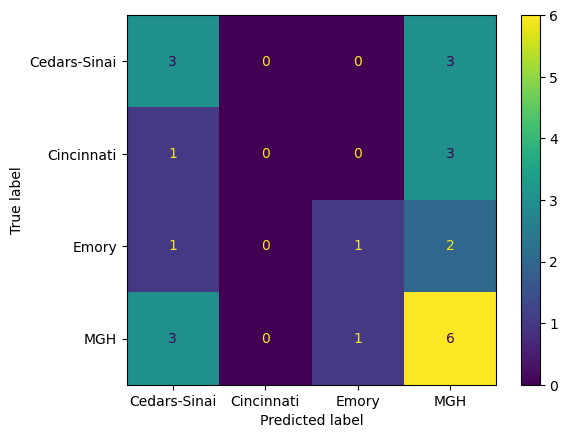

In [27]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=encoder.classes_).plot()
plt.show()

In [28]:
f1 = f1_score(y_test, y_pred, average='macro')
f1

0.31547619047619047